## Lab 8:  Clustering

Author: Eva Newby, Rachel Swick

Environmental justice (EJ) seeks to ensure that all communities, regardless of socioeconomic status or demographic background, have equal access to clean air, water, and, in the form of energy justice, access to renewable energy resources while minimizing exposure to environmental hazards. In this lab, we will apply clustering analysis to explore how U.S. counties group together based on renewable energy potential, demographic characteristics, and environmental risk factors.

The EEIP dataset was collated by the National Renewable Energy Lab (NREL) and contains a large set of features from multiple other databases including SLOPE (renewable energy potential) and EJSCREEN (environmental risk indicators).

Link to metadata: https://ucsb.box.com/s/x3olvh3rd8w5h7xz8jnm3v8g3t4ajjsg

First you will step through a guided clustering exploration of renewable energy production potential.  Then you will formulate a question of your own that brings in an environmental justice component.


### Step 0: Load Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Load the EEIP dataset 
eeip_data = pd.read_csv("/courses/EDS232/Data/eeip.data.csv")

## Part I:
In this part, we will step through an analysis that examines how US counties cluster in their potential production of renewable energy.  

### Step 1: Exploratory Data Analysis

First we need to check for missing data and remove incomplete rows. Since clustering is a distance-based technique, we also need to ensure that the features used for clustering are scaled appropriately to prevent dominant features from skewing results.  For our first analysis, use the following variables from the SLOPE dataset related to energy production potential as your features: 
- `utility_pv_technical_generation_potential_mwh`
- `residential_pv_technical_generation_potential_mwh`
- `land_based_wind_technical_generation_potential_mwh`
- `commercial_pv_technical_generation_potential_mwh`

*Information on these variables is available on line 7 of the ColumnsExplained tab of the metadata*

Once you have removed incomplete rows and scaled, print the shape of your processed dataframe. 

In [2]:
# Check for missing data
eeip_clean = eeip_data[["county_fips", 
                        "county",
                        "state",
                        "lowincome_pop_5_prop",
                        "respiratoryhazardairtoxics_5_prop",
                        "utility_pv_technical_generation_potential_mwh",
                        "residential_pv_technical_generation_potential_mwh",
                        "land_based_wind_technical_generation_potential_mwh",
                        "commercial_pv_technical_generation_potential_mwh"]].dropna()

# Check
print(eeip_clean.isna().sum())

county_fips                                           0
county                                                0
state                                                 0
lowincome_pop_5_prop                                  0
respiratoryhazardairtoxics_5_prop                     0
utility_pv_technical_generation_potential_mwh         0
residential_pv_technical_generation_potential_mwh     0
land_based_wind_technical_generation_potential_mwh    0
commercial_pv_technical_generation_potential_mwh      0
dtype: int64


In [3]:
# Scale 
scaler = StandardScaler()
eeip_scaled = scaler.fit_transform(eeip_clean[["utility_pv_technical_generation_potential_mwh",
                                               "residential_pv_technical_generation_potential_mwh",
                                               "land_based_wind_technical_generation_potential_mwh",
                                               "commercial_pv_technical_generation_potential_mwh"]])
# convert back to DF
scaled_df = pd.DataFrame(eeip_scaled, columns=["utility_pv_technical_generation_potential_mwh",
                                                     "residential_pv_technical_generation_potential_mwh",
                                                     "land_based_wind_technical_generation_potential_mwh",
                                                     "commercial_pv_technical_generation_potential_mwh"]).reset_index(drop=True)

# Print data frame shape
print(f"Processed eeip data frame shape:", scaled_df.shape)

Processed eeip data frame shape: (3107, 4)


### Step 2: Hierarchical Clustering Analysis

Now that we have preprocessed our dataset and standardized the energy potential features, we will use hierarchical clustering to explore how counties group together based on their energy potential.

A dendrogram is a tree-like visualization that shows how clusters are merged step by step. By analyzing the dendrogram, we can decide the optimal number of clusters by looking at the distance between merges.

Use `linkage()` to perform the clustering.  Use 'ward' for the `method` parameter, a method which minimizes the variance within clusters, producing well-balanced groups. We will first visualize the **full dendrogram** using `dendrogram` before deciding on a truncation strategy.


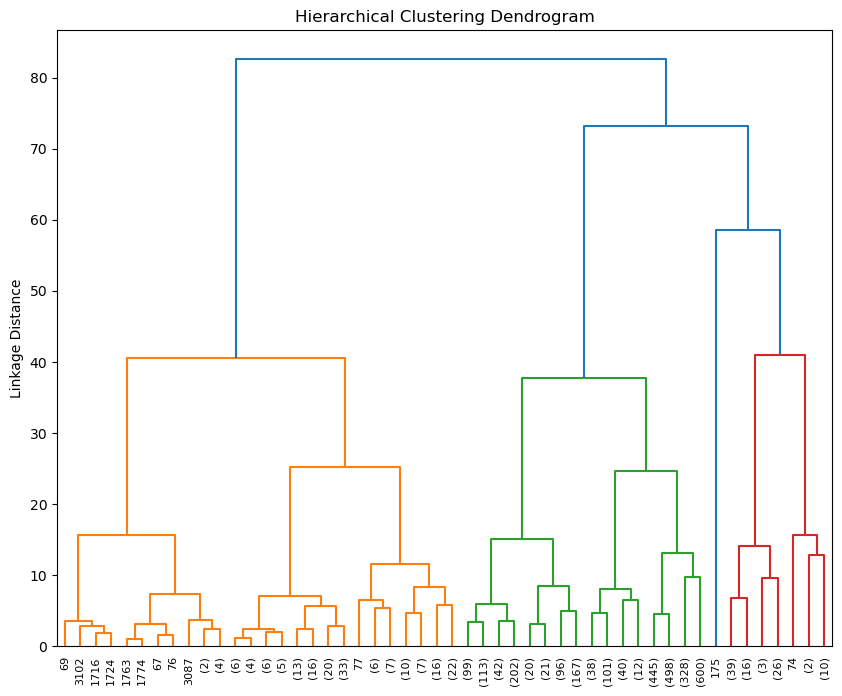

In [4]:
# Cluster using linkage
linkage_cluster = linkage(scaled_df, method = 'ward')

# Viz dendrogram
plt.figure(figsize=(10, 8))
dendrogram(linkage_cluster, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Linkage Distance")
plt.xlabel("")
plt.show()

### Step 3: Set Up Cluster Interpretation

After determining the optimal number of clusters from the dendrogram, we now assign each county to a cluster using the extracted cluster labels.

To better understand the clustering results, we will:
- Define `num_clusters` as the ideal number of clusters based on the dendrogram created above
- Extract cluster assignment attribute from the hierarchical clustering using `fcluster()` with `criterion = "maxclust"`
- Create a new variable `Cluster` in your cleaned dataframe and assign cluster labels to it
- Compute and print the mean values of the original energy potential features for each cluster.

This summary will help us interpret how counties differ in energy potential across clusters and inform possible next steps for analysis.


In [5]:
# Is the optimal number of clusters 4? 
# define num_clusters
num_clusters = 4 

# extract cluster assignment atributes
cluster_labels = fcluster(linkage_cluster, num_clusters, criterion="maxclust")

# create a new variable assign cluster labels to new variable
scaled_df["cluster"] = cluster_labels

# calculate mean values
cluster_summary = scaled_df.groupby("cluster").mean()

# print results
print(cluster_summary)

         utility_pv_technical_generation_potential_mwh  \
cluster                                                  
1                                             2.831068   
2                                            -0.184742   
3                                            -0.076363   
4                                            -0.661236   

         residential_pv_technical_generation_potential_mwh  \
cluster                                                      
1                                                -0.193351   
2                                                -0.121549   
3                                                 3.631745   
4                                                26.888227   

         land_based_wind_technical_generation_potential_mwh  \
cluster                                                       
1                                                 3.004580    
2                                                -0.185776    
3                         

### Step 4: Visualizing Energy Potential Across Clusters
Now that we have assigned cluster labels, we want to understand how energy potential differs across clusters. To do this, we will visualize these differences using a grouped bar chart.

Each bar should represent the mean value of an energy potential indicator for a specific cluster. These different patterns of potential is what caused the model to segregate the clusters in the way that it did.

<Figure size 1000x800 with 0 Axes>

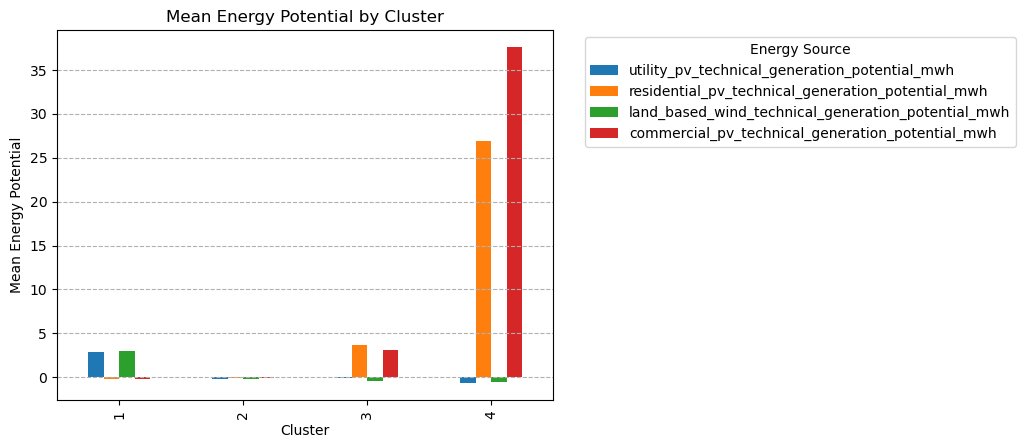

In [6]:
# find mean values
cluster_summary = scaled_df.groupby("cluster").mean()

# bar chart
plt.figure(figsize=(10, 8))
cluster_summary.plot(kind = 'bar')
plt.title("Mean Energy Potential by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Energy Potential")
plt.legend(title = "Energy Source", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis = "y", linestyle = "--")

### Step 5: Interpret Clustering Results
Interpret your plot of the resulting clusters.  How would you characterize and compare the four different clusters in terms of their profile of energy generation?

Cluster 4 stands out as the most energy-abundant region, driven mainly by its high residential and commercial PV potential. Cluster 1 has a more evenly distributed energy profile but a lower overall capacity than Cluster 4. Clusters 2 and 3 show limited energy potential, with Cluster 2 being the least productive. Regions with high energy potential are largely dominated by residential and commercial PV.

## Part II: Environmental Justice Metrics
Now it's your turn.

So far, we have clustered counties based on **energy potential**, but energy potential alone does not tell the full story of **energy equity and access**. To deepen the analysis, we need to consider environmental justice (EJ) factors that affect communities’ ability to benefit from renewable energy and the environmental burdens they already experience.

1. Explore EJSCREEN variables:  
   - The EJSCREEN subset of our dataset contains metrics on pollution burden, demographics (population size), and health risks (*lines 31-41 of the ColumnsExplained tab in the metadata sheet linked above*).
   - Identify 1-3 variables that could be important for energy equity analysis.  You could introduce them either as clustering features, as post-clustering variables to help interpret the clusters, or both. 

2. Modify the clustering approach:  
   - Add your selected EJSCREEN variables to our feature set.    
   - Re-run the hierarchical clustering analysis with the expanded dataset (if you added any as clustering features).  

3. Interpret the Results:
   Your interpretation could include considerations such as:
   - How do clusters change when EJSCREEN variables are included?  
   - Are counties with high renewable energy potential also burdened by environmental risks?  
   - What policy recommendations might emerge from these findings?  

In [7]:
# View first  5 rows
eeip_data.head()

,county_fips,county,state,county_pop,utilitypv_techpot_quint,utility_pv_technical_generation_potential_mwh,residentialpv_techpot_quint,residential_pv_technical_generation_potential_mwh,landbasedwind_techpot_quint,land_based_wind_technical_generation_potential_mwh,...,rmpprox_2_prop,rmpprox_3_prop,rmpprox_4_prop,rmpprox_5_prop,tsdf_indicator,tsdfprox_1_prop,tsdfprox_2_prop,tsdfprox_3_prop,tsdfprox_4_prop,tsdfprox_5_prop
0,1001,Autauga,AL,55200,3,3.585222e+07,4.0,122752.69,3,4374954.41,...,0.156250,0.031250,0.000000,0.0,0.0,0.343750,0.187500,0.281250,0.156250,0.03125
1,1003,Baldwin,AL,208107,5,1.257822e+08,5.0,483008.57,3,4368631.72,...,0.127660,0.031915,0.053191,0.0,0.0,0.521277,0.297872,0.159574,0.021277,0.00000
2,1005,Barbour,AL,25782,4,6.614827e+07,3.0,42823.79,3,5898864.51,...,0.173913,0.304348,0.130435,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.00000
3,1007,Bibb,AL,22527,2,1.926909e+07,2.0,37917.84,3,3986770.03,...,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.600000,0.066667,0.000000,0.00000
4,1009,Blount,AL,57645,2,2.261702e+07,4.0,122024.81,3,6117474.83,...,0.085714,0.057143,0.000000,0.0,0.0,0.714286,0.171429,0.114286,0.000000,0.00000


In [14]:
# Select 5th national quintile for percent low income and the National Scale Air Toxics Assessment Respiratory Hazard Index columns
eeip_ej_var = eeip_clean[["lowincome_pop_5_prop",
                           "respiratoryhazardairtoxics_5_prop"]].reset_index(drop=True)

# Combine the EJSCREEN columns with the scaled data
ej_df = pd.concat([eeip_ej_var, scaled_df], axis=1)
ej_df.head()

# Compute Mean values of the energy potential features for each cluster
ej_means = ej_df.groupby(['cluster']).mean()
print(ej_means)

         lowincome_pop_5_prop  respiratoryhazardairtoxics_5_prop  \
cluster                                                            
1                    0.195722                           0.008538   
2                    0.194740                           0.114116   
3                    0.193137                           0.203953   
4                    0.227393                           0.767395   

         utility_pv_technical_generation_potential_mwh  \
cluster                                                  
1                                             2.831068   
2                                            -0.184742   
3                                            -0.076363   
4                                            -0.661236   

         residential_pv_technical_generation_potential_mwh  \
cluster                                                      
1                                                -0.193351   
2                                                -0.1215

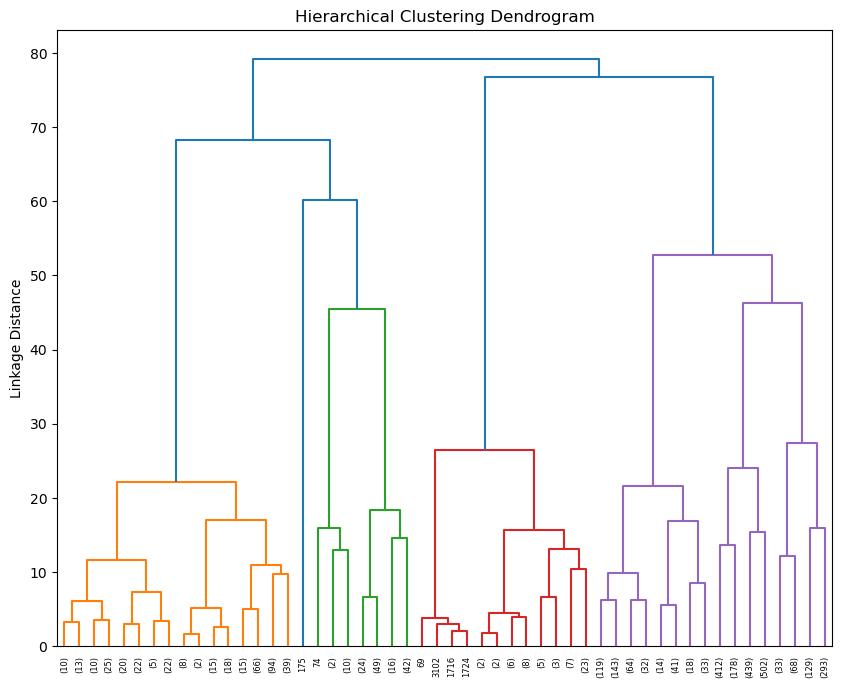

In [15]:
# Scale data
eeip_ej_scaled = scaler.fit_transform(eeip_clean[["lowincome_pop_5_prop",
                                                  "respiratoryhazardairtoxics_5_prop",
                                                  "utility_pv_technical_generation_potential_mwh",
                                                  "residential_pv_technical_generation_potential_mwh",
                                                  "land_based_wind_technical_generation_potential_mwh",
                                                  "commercial_pv_technical_generation_potential_mwh"]])

# Convert back to a DataFrame
scaled_ej_df = pd.DataFrame(eeip_ej_scaled, columns=["lowincome_pop_5_prop",
                                                     "respiratoryhazardairtoxics_5_prop",
                                                     "utility_pv_technical_generation_potential_mwh",
                                                     "residential_pv_technical_generation_potential_mwh",
                                                     "land_based_wind_technical_generation_potential_mwh",
                                                     "commercial_pv_technical_generation_potential_mwh"]).reset_index(drop=True)

# Hierarchical clustering
eeip_ej_linked = linkage(scaled_ej_df, 'ward')

# Viz dendrogram
plt.figure(figsize=(10, 8))
dendrogram(eeip_ej_linked, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Linkage Distance")
plt.xlabel("")
plt.show()

         lowincome_pop_5_prop  respiratoryhazardairtoxics_5_prop  \
cluster                                                            
1                    0.751287                           2.408441   
2                   -0.101232                           0.236633   
3                    0.745666                          -0.305910   
4                   -0.126511                          -0.373629   

         utility_pv_technical_generation_potential_mwh  \
cluster                                                  
1                                            -0.247524   
2                                            -0.226421   
3                                             5.032632   
4                                            -0.069133   

         residential_pv_technical_generation_potential_mwh  \
cluster                                                      
1                                                -0.051766   
2                                                 2.9846

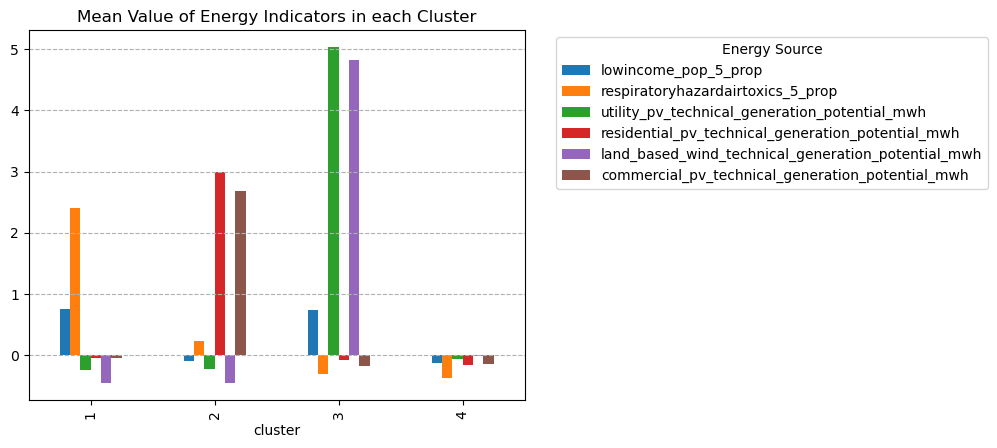

In [16]:
# Set the number of clusters based on the dendrogram
num_clusters_ej = 4

# Extract cluster assignments
cluster_labels_ej = fcluster(Z=eeip_ej_linked, t=num_clusters_ej, criterion='maxclust') 

# Add a new column `cluster` to the cleaned datframe
scaled_ej_df['cluster'] = cluster_labels_ej

# Mean values of the energy potential features for each cluster
ej_energy_means = scaled_ej_df.groupby(['cluster']).mean()
print(ej_energy_means)

# Grouped bar chart viz
ej_energy_means.reset_index().plot(x='cluster', 
                                   kind='bar', 
                                   stacked=False, 
                                   title='Mean Value of Energy Indicators in each Cluster') 
plt.legend(title = "Energy Source", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis = "y", linestyle = "--")

Which EJSCREEN variable(s) did you add to the analysis? Why did you choose these?  What is the question you are interested in? What did you learn from the analysis?

Two variables were added: "lowincome_pop_5_prop" and "respiratoryhazardairtoxics_5_prop". These represent the proportion of census block groups within each county that fell within the 5th national quintile for percent low income and the National Scale Air Toxics Assessment Respiratory Hazard Index. I chose these variables to help link socioeconomic factors to  energy potential. My main motivation in chosing these variables were to explore if areas with high renewable energy potential also have communities that have lower incomes and a higher exposure risk to hazardous respiratory chemicals. 

Cluster 3 has the highest residential PV and wind potential, but also significant respiratory hazards and many low-income residents, making it ideal for clean energy and health-focused projects. Cluster 1, with moderate renewable potential and notable pollution exposure, requires targeted clean energy solutions. Cluster 4 has low air toxics exposure but limited renewable energy potential, reflecting a distinct profile. Cluster 2 combines high commercial PV potential with moderate pollution exposure and fewer low-income residents, showing a mixed profile.